In [226]:
import requests
import json
from pathlib import Path
import glob
import time
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

In [333]:
def num_files(tier_code):
    files = glob.glob('./data/match_info/%d*.json'%tier_code)
    print(f"There exist {len(files):>5} files for tier_code {tier_code}")

In [334]:
def summoner_in_match(path):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    return summoner_list

In [335]:
def is_summoner(path, summoner_name, lane):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    pId = None
    try:
        pId = summoner_list.index(summoner_name)
    except ValueError:
        return False
    return (lane == None) or (file_dic['participants'][pId]['timeline']['lane'] == lane)

In [336]:
def match_by_summoner(summoner_name, lane = None):
    matches = []
    for tier in range(1,6):
        print(f"Searching Tier Code {tier}")
        num_matches = len(matches)
        files = glob.glob(f'./data/match_info/{tier}*.json')
        for file in files:
            if is_summoner(file, summoner_name, lane):
                matches.append(file)
        if(num_matches != len(matches)):
            break
    return matches

In [337]:
def generate_sumlist():
    summoners = {}
    files = glob.glob('./data/match_info/*')
    files_num = len(files)
    count = 0
    start_time = time.time()
    for file in files:
        count = count + 1
        sum_list = summoner_in_match(file)
        for summonor in sum_list:
            if(summonor not in summoners):
                summoners[summonor] = 1
            else:
                summoners[summonor] = summoners[summonor] + 1
        print(f'{count}/{files_num}', end = '\r')
    print(time.time()-start_time)
    return summoners

In [338]:
def pts_extracter(match_id, summoner_name):
    timeline_path = f'./data/match_timeline/{match_id}.json'
    info_path = f'./data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    for parts in info_dic['participantIdentities']:
        if(parts['player']['summonerName'] == summoner_name):
            ingameId = parts['participantId']
            break
    x = []
    y = []
    count = 0
    for frame in tl_dic['frames']:
        if count > 10:
            break
        try:
            x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
            y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
            for event in frame['events']:
                if (event['type'] == 'CHAMPION_KILL'):
                    if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                        x.append(event['position']['x'])
                        y.append(event['position']['y'])
        except:
            pass
        count += 1
    return x,y

In [384]:
def jg_pts_extracter(match_id, summoner_name):
    timeline_path = f'./data/match_timeline/{match_id}.json'
    info_path = f'./data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    team = None
    for pId, parts in enumerate(info_dic['participants']):
        if(parts['timeline']['lane'] == 'JUNGLE' and info_dic['participantIdentities'][pId]['player']['summonerName'] == summoner_name):
            ingameId = pId + 1
            team = 'blue' if parts['teamId'] == 100 else 'red'
            break
            
    x = []
    y = []
    count = 0
    if ingameId != 0:
        for frame in tl_dic['frames']:
            if count > 10:
                break
            if count != 0:
                tmp_x = []
                tmp_y = []
                try:
                    tmp_x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
                    tmp_y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
                    for event in frame['events']:
                        if (event['type'] == 'CHAMPION_KILL'):
                            if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                                tmp_x.append(event['position']['x'])
                                tmp_y.append(event['position']['y'])
                except:
                    pass
                x.append(tmp_x)
                y.append(tmp_y)
            count += 1
    return x, y, team

In [456]:
def heatmap(x, y, s, bins):
    heatmap, xedge, yedge = np.histogram2d(x, y, range = [[0, 15000], [0, 15000]], bins=bins)    
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T

def show_heat_scatter(pts_dict,s, bins = 500, markersize = 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig = plt.figure(figsize=(5,10))
    extent = [0,15000,0,15000]
    
    axs[0].plot(pts_dict['blue']['x'], pts_dict['blue']['y'], 'b.', markersize=markersize)
    axs[0].set_xlim([0, 15000])
    axs[0].set_ylim([0, 15000])
    axs[0].set_title("Blue team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[0].imshow(img, zorder=0, extent=extent)

    heat_blue = heatmap(pts_dict['blue']['x'], pts_dict['blue']['y'], s, bins)
    axs[1].imshow(heat_blue, extent = extent, origin='lower', cmap=cm.jet)
    axs[1].set_title("Blue team, Smoothing with  $\sigma$ = %d" % s)
    
    axs[2].plot(pts_dict['red']['x'], pts_dict['red']['y'], 'b.', markersize=markersize)
    axs[2].set_xlim([0, 15000])
    axs[2].set_ylim([0, 15000])
    axs[2].set_title("Red team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[2].imshow(img, zorder=0, extent=extent)
    
    heat_red = heatmap(pts_dict['red']['x'], pts_dict['red']['y'], s, bins)
    axs[3].imshow(heat_red, extent = extent, origin='lower', cmap=cm.jet)
    axs[3].set_title("red team, Smoothing with  $\sigma$ = %d" % s)
    plt.show()

In [10]:
def get_itemname(items_dic, item_id):
    try:
        return items_dic['data'][f'{item_id}']['name']
    except:
        return (f"INVALID_ITEM(id : {item_id})")

In [11]:
#destroy, undo, purchsed, sold
def item_tech(match_id, part_id):
    tl = Path(f"./data/match_timeline/{match_id}.json").read_bytes()
    tl_dic = json.loads(tl.decode())
    
    #local
    #items = Path("./data/item_cdn.json").read_bytes()
    #items_dic = json.loads(items.decode())
    
    #online
    version = "10.16.1"
    items_dic = (requests.get(f"http://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/item.json")).json()
    
    inventory = []
    minutes = 0
    for frame in tl_dic['frames']:
        past_inv = inventory.copy()
        if len(frame['events']) == 0:
            continue
        else:
            for event in frame['events']:
                try: 
                    if event['participantId'] == part_id:
                        event_time = time.strftime("%M:%S", time.gmtime(event['timestamp']/1000))
                        if event['type'] == "ITEM_PURCHASED":
                            inventory.append(event["itemId"])
                            #print(f'\t{event_time}  Purchased {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_SOLD":
                            del inventory[inventory.index(event["itemId"])]
                            print(f'\t- {event_time}  Sold {get_itemname(items_dic, event["itemId"])} ', end ='')
                            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))
                        elif event['type'] == "ITEM_DESTROYED":
                            del inventory[inventory.index(event["itemId"])]
                            #print(f'\t{event_time}  Destroyed {get_itemname(items_dic, event["itemId"])}')
                        elif event['type'] == "ITEM_UNDO":
                            inventory.append(event["afterId"])
                            del inventory[inventory.index(event["beforeId"])]
                            #print(f'\t{event_time}  Undo {get_itemname(items_dic, event["beforeId"])} to {get_itemname(items_dic, event["afterId"])}')
                        else:
                            continue
                    else:
                        continue
                except:
                    pass
        minutes = minutes + 1
        while(0 in inventory):
            del inventory[inventory.index(0)]
        if (past_inv != inventory):
            print(f"- {minutes} min : ", end ='')
            print(list(map(lambda x : get_itemname(items_dic, x), inventory)))

In [228]:
for i in range(1,6):
    num_files(i)

There exist  7235 files for tier_code 1
There exist  4623 files for tier_code 2
There exist  3600 files for tier_code 3
There exist  3600 files for tier_code 4
There exist  3600 files for tier_code 5


In [342]:
files = glob.glob('./data/match_info/*.json')
summoner_dict = {}
start_time = time.time()
for file in files:
    summoners = summoner_in_match(file)
    for summoner in summoners:
        if summoner in summoner_dict:
            summoner_dict[summoner] += 1
        else:
            summoner_dict[summoner] = 1
print(time.time()-start_time)

8.227526426315308


In [343]:
major_summoners = [key for key in summoner_dict if summoner_dict[key] > 100]

Searching Tier Code 1
There exist 100 matches
idx : 0, summoner name : Youtube 연습생, 33 blue, 35 red, total 68 matches!


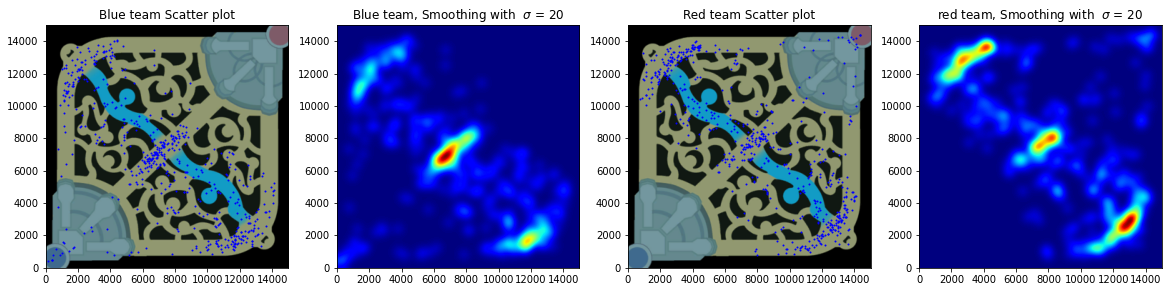

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
Searching Tier Code 2
Searching Tier Code 3
There exist 101 matches
idx : 1, summoner name : 플레티넘 녹턴, 31 blue, 37 red, total 68 matches!


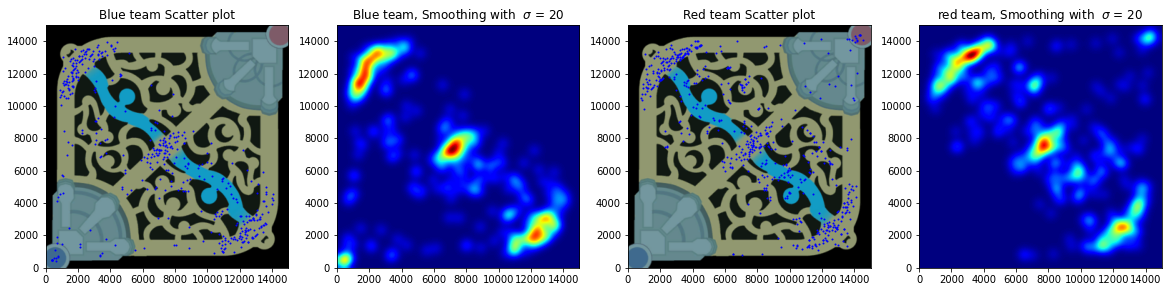

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 1 matches
idx : 2, summoner name : 지뉴누리늉, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 101 matches
idx : 3, summoner name : 희 바, 3 blue, 5 red, total 8 matches!


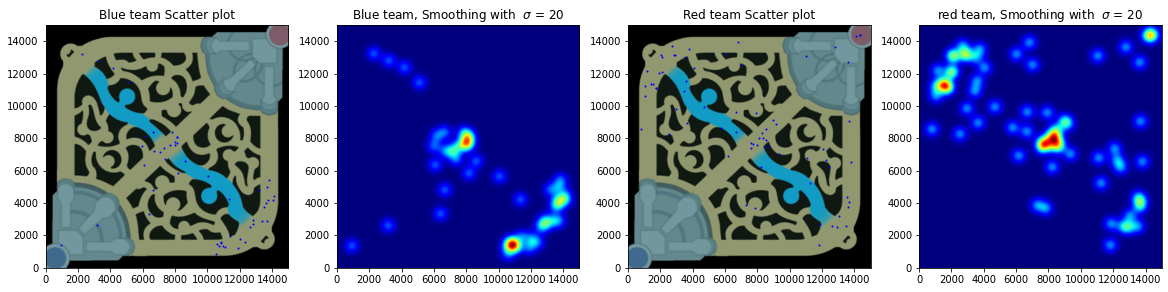

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 1 matches
idx : 4, summoner name : zxczzxc, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 101 matches
idx : 5, summoner name : 뱅 좌, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 1 matches
idx : 6, summoner name : 원딜학교 문제아, 1 blue, 0 red, total 1 matches!


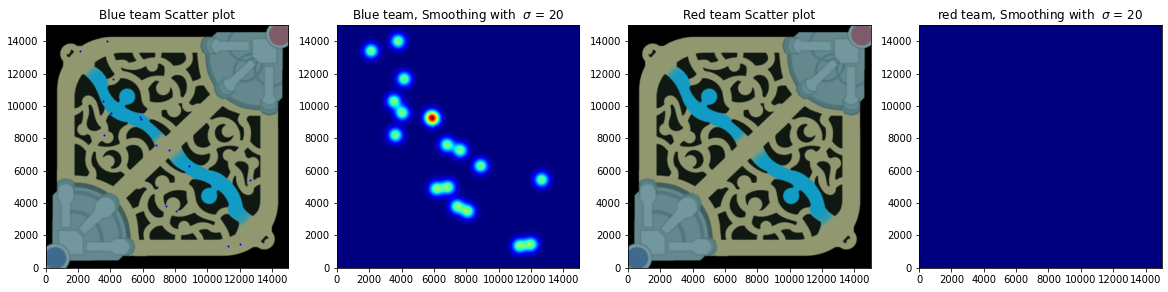

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 101 matches
idx : 7, summoner name : 성북동마카롱, 0 blue, 2 red, total 2 matches!


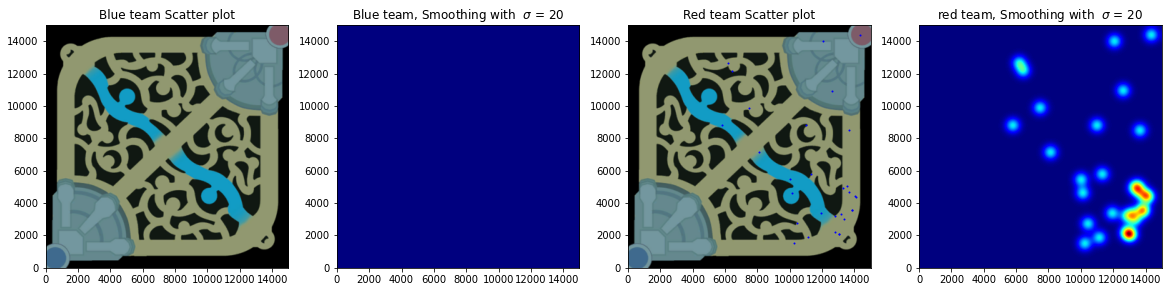

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 102 matches
idx : 8, summoner name :  제야요, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 3 matches
idx : 9, summoner name : 안개마녀 오빠, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 100 matches
idx : 10, summoner name : 재훈박, 2 blue, 5 red, total 7 matches!


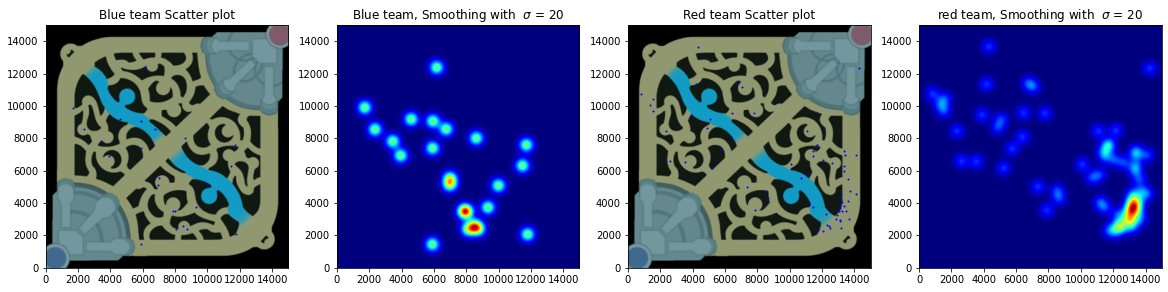

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
Searching Tier Code 2
There exist 100 matches
idx : 11, summoner name : voyez, 34 blue, 29 red, total 63 matches!


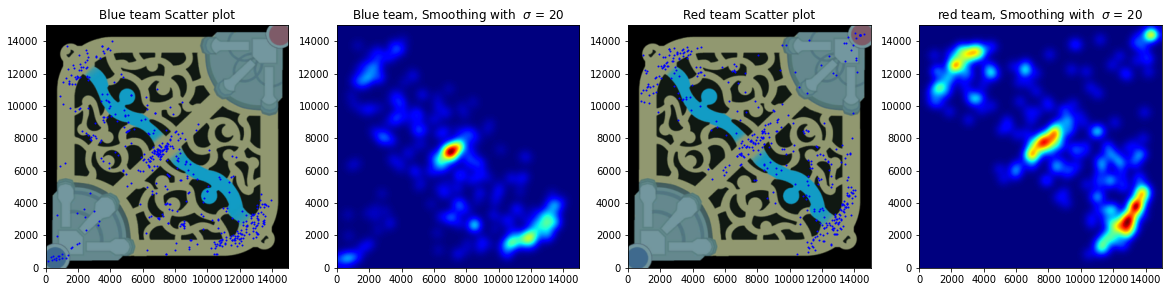

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 102 matches
idx : 12, summoner name : 마스터들다죽어, 2 blue, 0 red, total 2 matches!


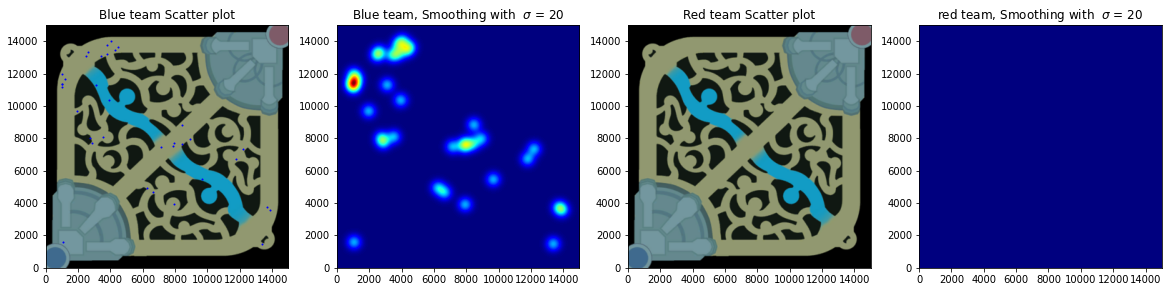

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
Searching Tier Code 2
There exist 1 matches
idx : 13, summoner name : Holy쒸트, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 1 matches
idx : 14, summoner name : 거기사람없나요, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 1 matches
idx : 15, summoner name : zxcvbcxvzx, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 102 matches
idx : 16, summoner name : sonmoksnap, 0 blue, 1 red, total 1 matches!


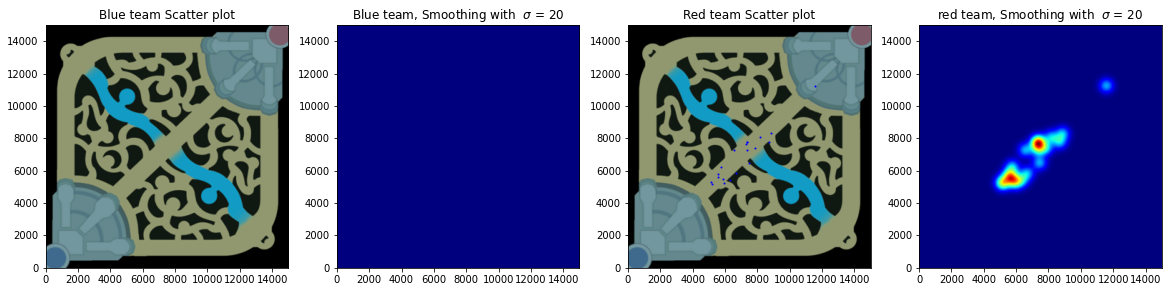

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 100 matches
idx : 17, summoner name : 배누리, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 1 matches
idx : 18, summoner name : skt tI eftort, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 101 matches
idx : 19, summoner name : 내가다잡을게비켜, 1 blue, 8 red, total 9 matches!


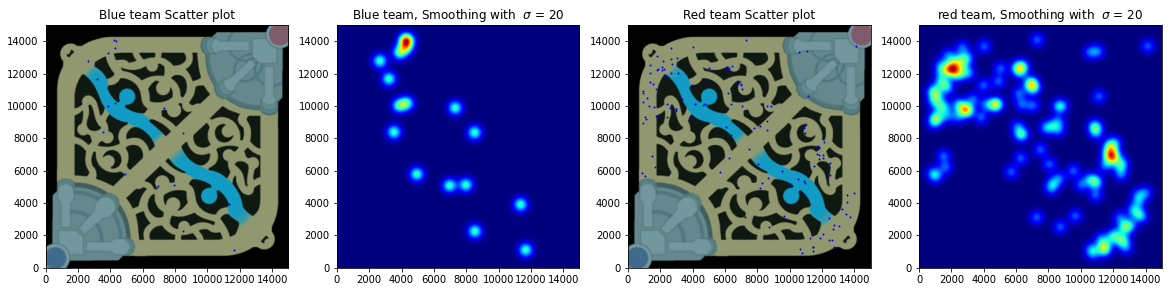

<Figure size 360x720 with 0 Axes>

Searching Tier Code 1
There exist 1 matches
idx : 20, summoner name : 야새로이, 0 blue, 0 red, total 0 matches!
Not Jungle User
Searching Tier Code 1
There exist 100 matches
idx : 21, summoner name : 코너캔디샵, 3 blue, 2 red, total 5 matches!


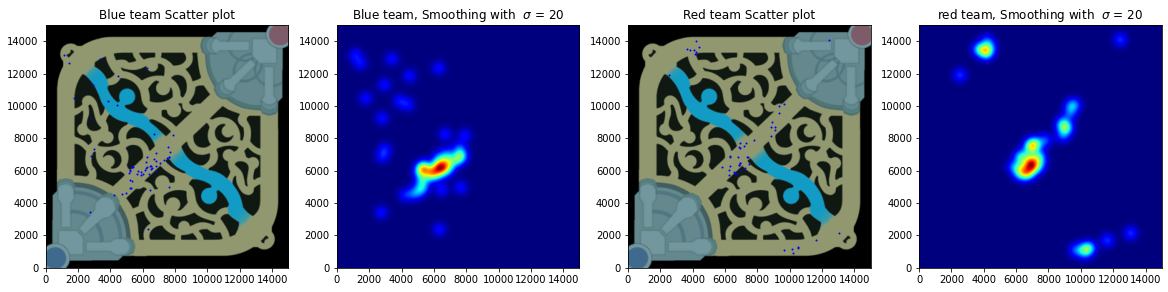

<Figure size 360x720 with 0 Axes>

In [385]:
for idx, target_summoner in enumerate(major_summoners):
    mts = match_by_summoner(target_summoner)
    print(f'There exist {len(mts)} matches')

    pts = {'blue' : {'x' : [], 'y' : []}, 'red' : {'x' : [], 'y' : []}}
    blue_jg_count = 0
    red_jg_count = 0
    for index in range(len(mts)):
        tmp_x, tmp_y, team = jg_pts_extracter(mts[index][18:-5], target_summoner)
        if team == None:
            continue
        pts[team]['x'] += [y for x in tmp_x for y in x]
        pts[team]['y'] += [y for x in tmp_y for y in x]
        if team == 'blue':
            blue_jg_count += 1
        else:
            red_jg_count += 1
    print(f"idx : {idx}, summoner name : {target_summoner}, {blue_jg_count} blue, {red_jg_count} red, total {blue_jg_count+red_jg_count} matches!")
    if blue_jg_count+red_jg_count != 0:
        show_heat_scatter(pts,20,1000)
    else:
        print("Not Jungle User")

In [192]:
# item_tech(mts[1][18:-5],1)

In [345]:
t_mts = match_by_summoner(major_summoners[0], 'JUNGLE')

Searching Tier Code 1


In [442]:
pts = {'blue' : {'x' : [], 'y' : []}, 'red' : {'x' : [], 'y' : []}}
blue_jg_count = 0
red_jg_count = 0
for index in range(len(t_mts)):
    tmp_x, tmp_y, team = jg_pts_extracter(t_mts[index][18:-5], major_summoners[0])
    if team == None:
        continue
    pts[team]['x'] += tmp_x
    pts[team]['y'] += tmp_y
    if team == 'blue':
        blue_jg_count += 1
    else:
        red_jg_count += 1

In [429]:
def sort_pts_by_time(pts_list):
    pts = []
    frames = 10
    for timelen in range(frames):
        pts.append([])
        for match_num in range((int)(len(pts_list)/frames)):
            pts[timelen] += pts_list[match_num*10 + timelen]
    return pts

In [453]:
b_x = sort_pts_by_time(pts['blue']['x'])
b_y = sort_pts_by_time(pts['blue']['y'])
r_x = sort_pts_by_time(pts['red']['x'])
r_y = sort_pts_by_time(pts['red']['y'])

1 minutes


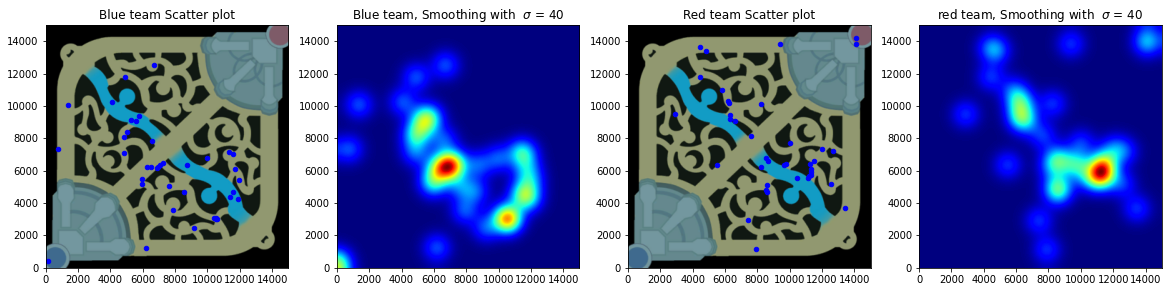

<Figure size 360x720 with 0 Axes>

2 minutes


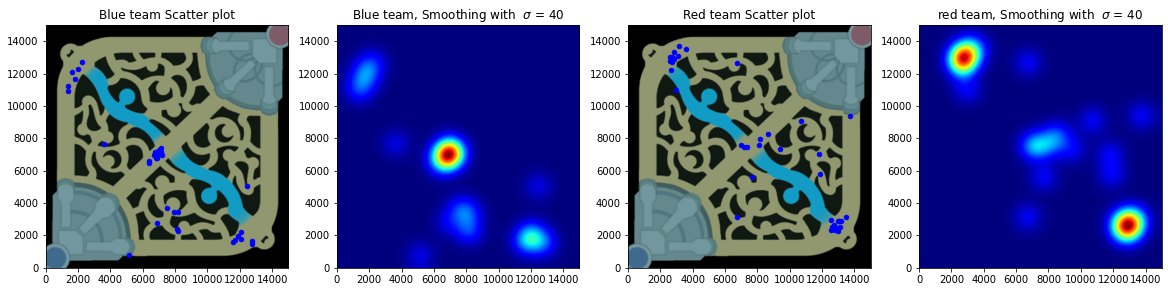

<Figure size 360x720 with 0 Axes>

3 minutes


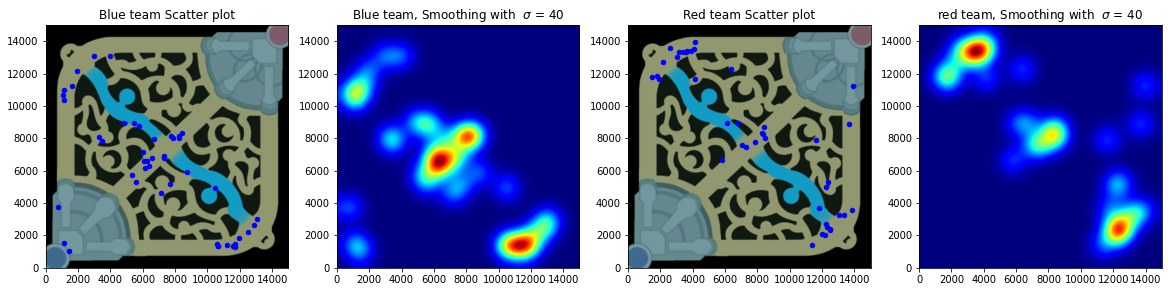

<Figure size 360x720 with 0 Axes>

4 minutes


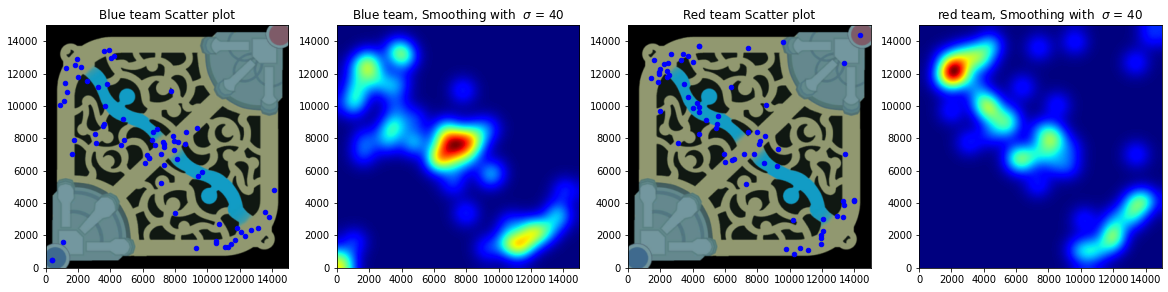

<Figure size 360x720 with 0 Axes>

5 minutes


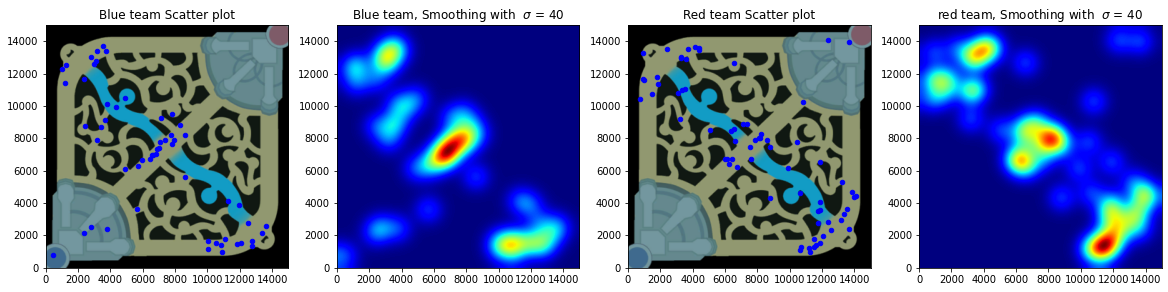

<Figure size 360x720 with 0 Axes>

6 minutes


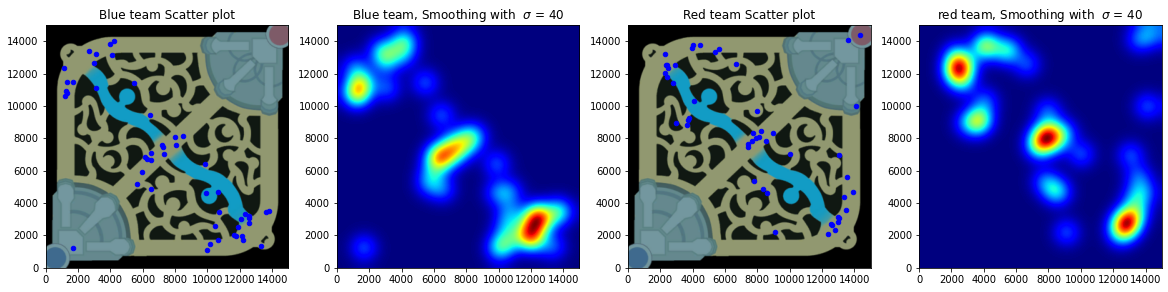

<Figure size 360x720 with 0 Axes>

7 minutes


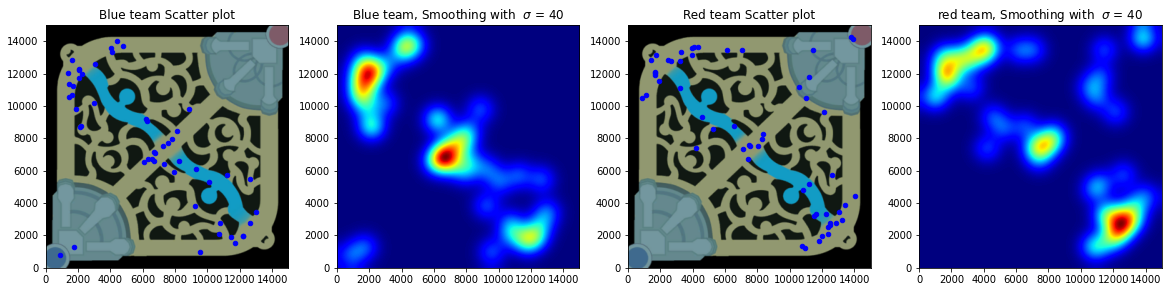

<Figure size 360x720 with 0 Axes>

8 minutes


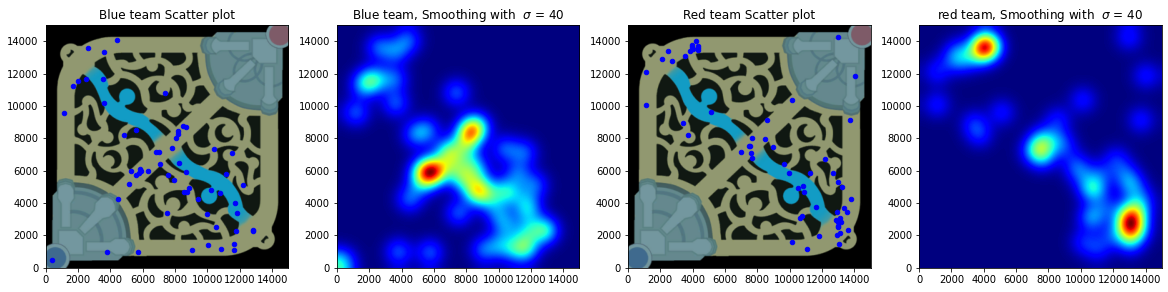

<Figure size 360x720 with 0 Axes>

9 minutes


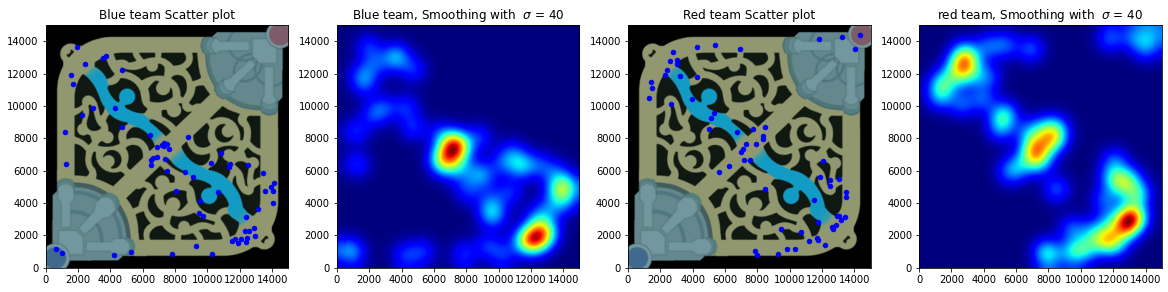

<Figure size 360x720 with 0 Axes>

10 minutes


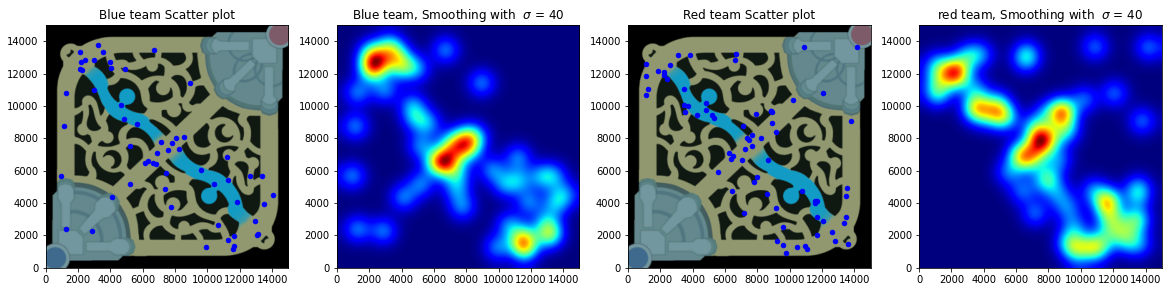

<Figure size 360x720 with 0 Axes>

In [462]:
for frame in range(10):
    print(f'{frame+1} minutes')
    show_heat_scatter({'blue' : {'x' : b_x[frame], 'y' : b_y[frame]}, 'red' : {'x' : r_x[frame], 'y' : r_y[frame]}},40,1000, markersize=9)